In [1]:
# 📦 Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
# 📥 Load Dataset
print("Loading dataset...")
data_org = pd.read_excel('World_development_mesurement.xlsx')
data = data_org.copy()
print("Initial shape:", data.shape)


Loading dataset...
Initial shape: (2704, 25)


In [3]:
# 🔤 Encode Country and Clean Symbols
print("Encoding 'Country' column and cleaning currency/percentage symbols...")
data['Country_encoded'] = LabelEncoder().fit_transform(data['Country'])
country_names = data['Country']
data.drop(['Country'], axis=1, inplace=True)

def clean_currency(col):
    return pd.to_numeric(col.astype(str).str.replace('$','',regex=True).str.replace(',',''), errors='coerce')

currency_cols = ['GDP', 'Health Exp/Capita', 'Tourism Inbound', 'Tourism Outbound']
for col in currency_cols:
    if col in data.columns:
        data[col] = clean_currency(data[col])

if 'Business Tax Rate' in data.columns:
    data['Business Tax Rate'] = pd.to_numeric(data['Business Tax Rate'].astype(str).str.replace('%','',regex=True), errors='coerce')

if 'Number of Records' in data.columns:
    data.drop(['Number of Records'], axis=1, inplace=True)


Encoding 'Country' column and cleaning currency/percentage symbols...


In [11]:
# 🧹 Final Missing Value Imputation
print("Checking and imputing all remaining missing values...")

# Mean imputation for numeric columns
for col in data.columns:
    if data[col].dtype in ['float64', 'int64']:
        if data[col].isnull().sum() > 0:
            # Use mean if the column is roughly symmetric, else median
            skewness = data[col].skew()
            if abs(skewness) < 1:
                data[col] = data[col].fillna(data[col].mean())
                print(f"Filled missing values in '{col}' with mean.")
            else:
                data[col] = data[col].fillna(data[col].median())
                print(f"Filled missing values in '{col}' with median.")

# Final check
print("✅ Remaining missing values:", data.isnull().sum().sum())


Checking and imputing all remaining missing values...
✅ Remaining missing values: 0


In [12]:
# 📦 Outlier Removal using IQR
print("Removing outliers using IQR method...")
data1 = data.copy()
Q1 = data1.quantile(0.25)
Q3 = data1.quantile(0.75)
IQR = Q3 - Q1
data1 = data1[~((data1 < (Q1 - 1.5 * IQR)) | (data1 > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Shape after outlier removal:", data1.shape)


Removing outliers using IQR method...
Shape after outlier removal: (1225, 24)


In [13]:
# 📏 Standardize and Apply PCA
print("Standardizing features and applying PCA...")
def apply_pca(df, n_components=15):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    pca = PCA()
    components = pca.fit_transform(scaled)
    return components[:, :n_components], pca

data_pca1, pca1 = apply_pca(data1)
data_pca2, pca2 = apply_pca(data.copy())


Standardizing features and applying PCA...


Plotting cumulative variance explained by PCA components...


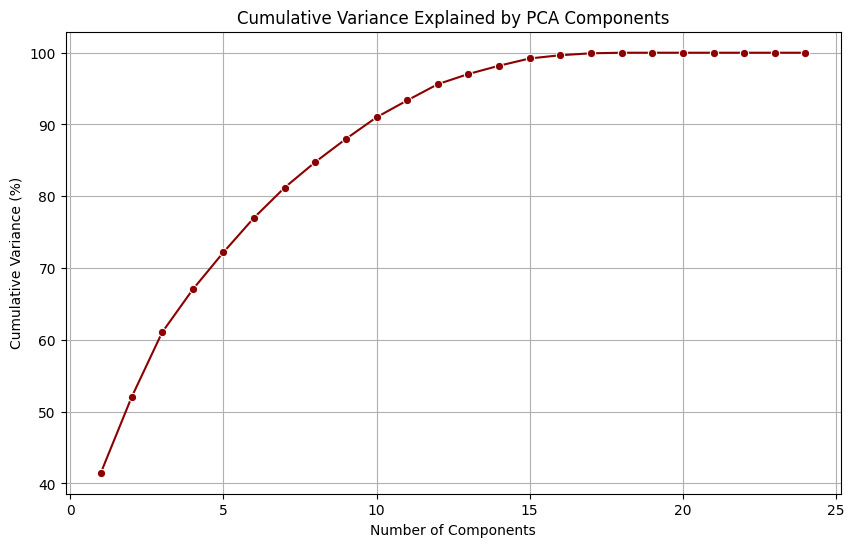

In [14]:
# 📉 PCA Variance Plot
print("Plotting cumulative variance explained by PCA components...")
var_ratio = pca1.explained_variance_ratio_
cumulative_var = np.cumsum(np.round(var_ratio, decimals=4)*100)

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(cumulative_var)+1), y=cumulative_var, marker='o', color='darkred')
plt.title("Cumulative Variance Explained by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance (%)")
plt.grid(True)
plt.show()


Using Elbow Method to determine optimal number of clusters...


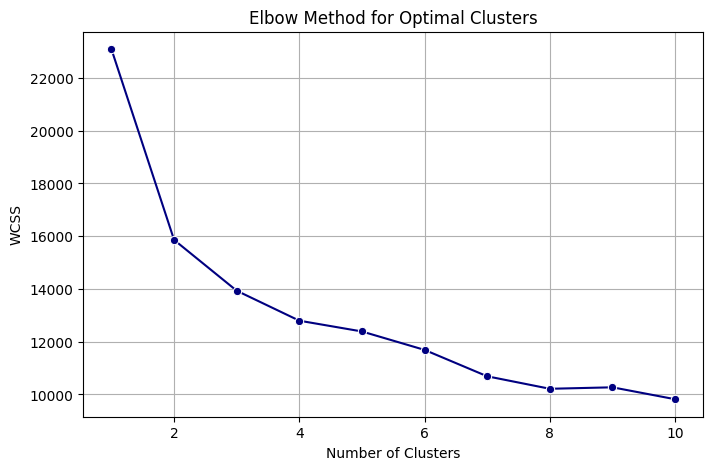

In [15]:
# 🔢 Elbow Method for K-Means
print("Using Elbow Method to determine optimal number of clusters...")
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data_pca1)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 11), y=wcss, marker='o', color='navy')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()


In [18]:
# 🧪 Clustering Function
print("Defining clustering function for K-Means, Hierarchical, and DBSCAN...")
def clustering_analysis(data_pca, method_name):
    scores = {}

    kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
    labels_kmeans = kmeans.fit_predict(data_pca)
    scores[f'{method_name} kmeans'] = silhouette_score(data_pca, labels_kmeans)

    hc = AgglomerativeClustering(n_clusters=4, linkage='ward')
    labels_hc = hc.fit_predict(data_pca)
    scores[f'{method_name} hierarchy'] = silhouette_score(data_pca, labels_hc)

    dbscan = DBSCAN(eps=0.5 if method_name == 'M1' else 0.2, min_samples=5)
    labels_dbscan = dbscan.fit_predict(data_pca)
    scores[f'{method_name} DBSCAN'] = silhouette_score(data_pca, labels_dbscan) if len(set(labels_dbscan)) > 1 else np.nan

    return scores, labels_kmeans, labels_hc, labels_dbscan


Defining clustering function for K-Means, Hierarchical, and DBSCAN...


In [19]:
# 🧠 Run Clustering for Method 1 and 2
print("Running clustering for Method 1 (outliers removed)...")
scores_m1, m1_kmeans, m1_hc, m1_dbscan = clustering_analysis(data_pca1, 'M1')

print("Running clustering for Method 2 (outliers retained)...")
scores_m2, m2_kmeans, m2_hc, m2_dbscan = clustering_analysis(data_pca2, 'M2')


Running clustering for Method 1 (outliers removed)...
Running clustering for Method 2 (outliers retained)...


In [20]:
# 🌐 t-SNE + Clustering (Method 3)
print("Applying t-SNE and clustering for Method 3...")
tsne = TSNE(random_state=42)
data_tsne = tsne.fit_transform(data1)

kmeans = KMeans(n_clusters=3, random_state=42)
tsne_kmeans = kmeans.fit_predict(data_tsne)
s3_kmeans = silhouette_score(data_tsne, tsne_kmeans)

hc = AgglomerativeClustering(n_clusters=4)
tsne_hc = hc.fit_predict(data_tsne)
s3_hierarchy = silhouette_score(data_tsne, tsne_hc)

scores_m3 = {
    'M3 kmeans': s3_kmeans,
    'M3 hierarchy': s3_hierarchy
}


Applying t-SNE and clustering for Method 3...


Comparing silhouette scores across all clustering methods...


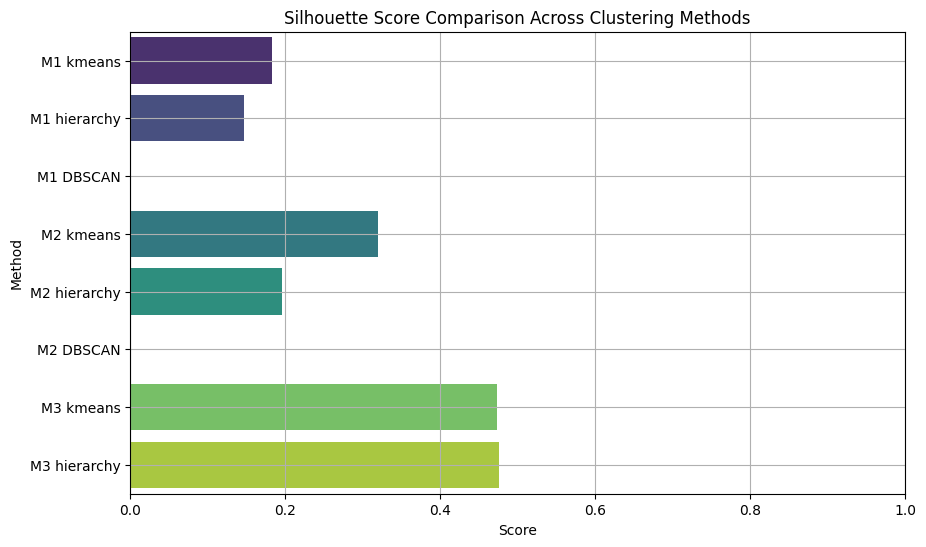

In [21]:
# 📊 Silhouette Score Comparison
print("Comparing silhouette scores across all clustering methods...")
all_scores = {**scores_m1, **scores_m2, **scores_m3}
df_scores = pd.DataFrame(list(all_scores.items()), columns=['Method', 'Silhouette Score'])

plt.figure(figsize=(10, 6))
sns.barplot(data=df_scores, x='Silhouette Score', y='Method', palette='viridis')
plt.title("Silhouette Score Comparison Across Clustering Methods")
plt.xlabel("Score")
plt.ylabel("Method")
plt.xlim(0, 1)
plt.grid(True)
plt.show()
